# Análise SVM

Neste notebook, iremos treinar um algoritmo SVM (Support Vector Machine) com nossos diferentes conjuntos de dados e analisar os resultados.

Faremos uma comparação de acurácia entre a divisão de dados em treinamento e teste e uma validação cruzada de 10 dobras. 

Em seguida, analisaremos profundamente o desempenho desses modelos por meio de métricas de desempenho.

O SVM é uma técnica poderosa para classificação que busca encontrar um hiperplano que melhor separa as classes em um espaço de características. 

A abordagem do SVM é particularmente eficaz em casos onde as classes não são linearmente separáveis, utilizando o truque do kernel para transformar os dados em um espaço de maior dimensão.

# 

# 0. Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC  # Importando a classe SVC para SVM
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import parallel_backend

# 

# 1. Organized By Slices

## &emsp;&emsp;&emsp;1.1 Non Normalized Dataset

In [2]:

# Lendo o conjunto de dados
df_by_slices = pd.read_csv("final_by_slices.csv")

# Separando as características do rótulo
X = df_by_slices.drop("malignancy", axis=1)
y = df_by_slices["malignancy"]


# Seleção de características
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Convertendo X_selected para um DataFrame
X_selected = pd.DataFrame(X_selected)
X_selected = X_selected.round(10)

# Criando conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
# Obtendo os índices das características selecionadas
selected_indices = selector.get_support(indices=True)
# Obtendo os nomes das características selecionadas
selected_features = X.columns[selected_indices]

# Imprimindo os nomes das características selecionadas
print("Características selecionadas:")
print(selected_features.tolist())
# Imprimindo as primeiras linhas de X_selected, X_reduced e y
print("Primeiras linhas de X_selected:")
print(X_selected[:5])  # Imprime as primeiras 5 linhas de X_selected


print("\nPrimeiras linhas de y:")
print(y.head())  # Imprime as primeiras 5 linhas de y



Características selecionadas:
['subtlety', 'calcification', 'lobulation', 'spiculation', 'diameter', 'surfaceArea', 'volume', 'diagnostics_Mask-original_VoxelNum', 'original_shape2D_MajorAxisLength', 'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface', 'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter', 'original_shape2D_PerimeterSurfaceRatio', 'original_shape2D_PixelSurface', 'original_shape2D_Sphericity', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_InverseVariance', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_SumEntropy', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphas

In [4]:
# Definindo os parâmetros para o GridSearch
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale'], 'kernel': ['rbf']}


# Criando o classificador SVM
svm = SVC(probability=True)

# Configurando o GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Ajustando o modelo
grid_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Usando o melhor modelo para prever no conjunto de teste
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Calculando a acurácia para a divisão de treino-teste
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia (Train-Test Split): {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))



Melhores parâmetros encontrados:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Acurácia (Train-Test Split): 0.80
Relatório de Classificação:
              precision    recall  f1-score   support

          -1       0.79      0.81      0.80      5153
           1       0.80      0.78      0.79      5047

    accuracy                           0.80     10200
   macro avg       0.80      0.80      0.80     10200
weighted avg       0.80      0.80      0.80     10200



In [4]:
# Calculando a acurácia para validação cruzada de 5 dobras
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    cv_scores = cross_val_score(best_svm, X_selected, y, cv=5)
print(f'Acurácia (10-Fold Cross Validation): {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')

Acurácia (10-Fold Cross Validation): 0.79 ± 0.02


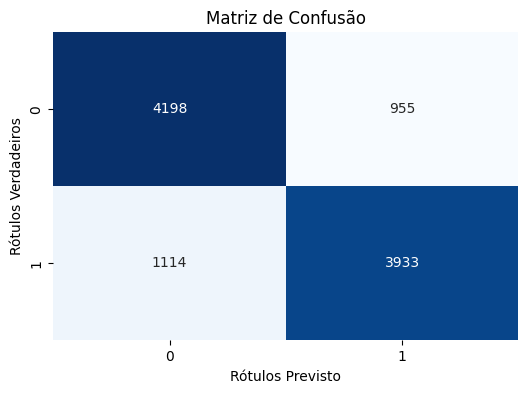

In [5]:
# Obtendo a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Rótulos Previsto')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()


#---------



AUC: 0.87


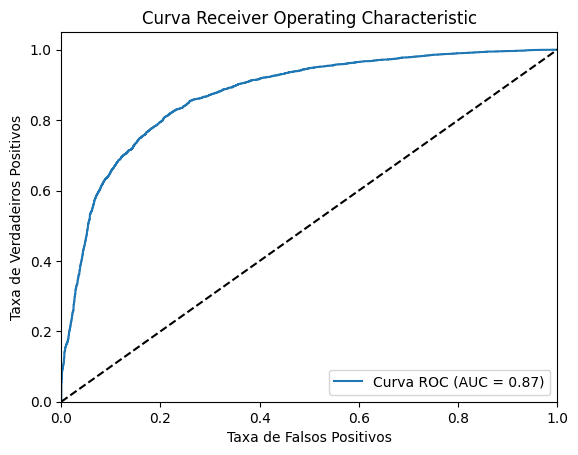

In [ ]:
# Probabilidades para a classe positiva (classe 1)
y_proba = best_svm.predict_proba(X_test)[:, 1]

# Obtendo AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {roc_auc:.2f}')

# Computando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Obtendo as curvas de aprendizado
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    train_sizes, train_scores, test_scores = learning_curve(
        best_svm, X_selected, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

# Calculando a média e desvio padrão das pontuações
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Acurácia de Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Acurácia de Teste', color='green')

# Preenchendo a área entre as curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.title('Curvas de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

## 

## &emsp;&emsp;&emsp;1.2 Normalized Dataset

In [ ]:
# Leitura do conjunto de dados
df_by_slices_normalized = pd.read_csv("final_by_slices_normalized.csv")

# Separação de recursos e rótulos
X = df_by_slices_normalized.drop("malignancy", axis=1)
y = df_by_slices_normalized["malignancy"]

# Seleção de características
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Convertendo X_selected para um DataFrame
X_selected = pd.DataFrame(X_selected)
X_selected = X_selected.round(10)


# Divisão do conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Obtendo os índices das características selecionadas
selected_indices = selector.get_support(indices=True)
# Obtendo os nomes das características selecionadas
selected_features = X.columns[selected_indices]

# Imprimindo os nomes das características selecionadas
print("Características selecionadas:")
print(selected_features.tolist())
# Imprimindo as primeiras linhas de X_selected, X_reduced e y
print("Primeiras linhas de X_selected:")
print(X_selected[:5])  # Imprime as primeiras 5 linhas de X_selected


print("\nPrimeiras linhas de y:")
print(y.head())  # Imprime as primeiras 5 linhas de y


In [ ]:
# Criação do classificador SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
# Ajuste do modelo SVM
svm_model.fit(X_train, y_train)

# Previsão com o modelo SVM
y_pred_svm = svm_model.predict(X_test)

# Cálculo da acurácia do modelo SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM (Train-Test Split): {accuracy_svm:.2f}')


# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

In [ ]:
# Cálculo da acurácia com validação cruzada para o modelo SVM usando Joblib
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    cv_scores_svm = cross_val_score(svm_model, X_selected, y, cv=5)

print(f'Acurácia média com validação cruzada (10 dobras): {cv_scores_svm.mean():.2f} ± {cv_scores_svm.std():.2f}')


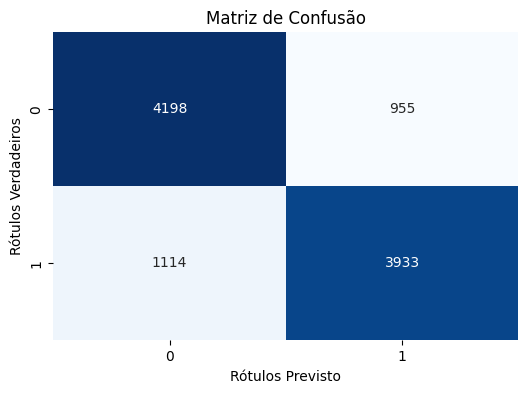

In [ ]:
# Obtendo a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Rótulos Previsto')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()


#---------



AUC: 0.87


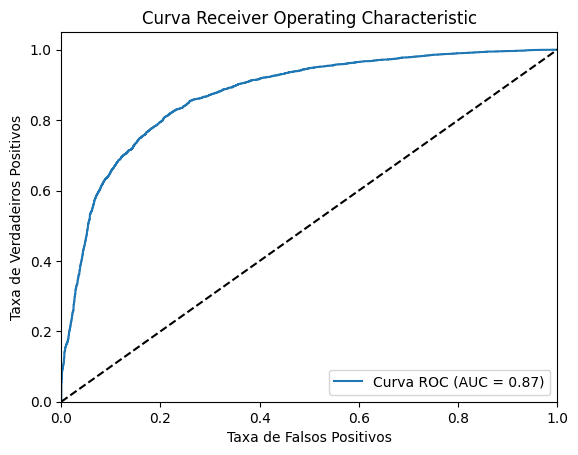

In [ ]:
# Probabilidades para a classe positiva (classe 1)
y_proba = svm_model.predict_proba(X_test)[:, 1]

# Obtendo AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {roc_auc:.2f}')

# Computando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Obtendo as curvas de aprendizado
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    train_sizes, train_scores, test_scores = learning_curve(
        svm_model, X_selected, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

# Calculando a média e desvio padrão das pontuações
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Acurácia de Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Acurácia de Teste', color='green')

# Preenchendo a área entre as curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.title('Curvas de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

# 

# 2. Organized By Annotations

## &emsp;&emsp;&emsp;2.1 Non Normalized Dataset

In [ ]:
#reading the dataset
df_by_annotations = pd.read_csv("final_by_annotations.csv")

#separate the features from the label
X = df_by_annotations.drop("malignancy", axis=1)
y = df_by_annotations["malignancy"]
# Seleção de características
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Convertendo X_selected para um DataFrame
X_selected = pd.DataFrame(X_selected)
X_selected = X_selected.round(10)


# Divisão do conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Obtendo os índices das características selecionadas
selected_indices = selector.get_support(indices=True)
# Obtendo os nomes das características selecionadas
selected_features = X.columns[selected_indices]

# Imprimindo os nomes das características selecionadas
print("Características selecionadas:")
print(selected_features.tolist())
# Imprimindo as primeiras linhas de X_selected, X_reduced e y
print("Primeiras linhas de X_selected:")
print(X_selected[:5])  # Imprime as primeiras 5 linhas de X_selected


print("\nPrimeiras linhas de y:")
print(y.head())  # Imprime as primeiras 5 linhas de y

In [ ]:
# Criação do classificador SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
# Ajuste do modelo SVM
svm_model.fit(X_train, y_train)

# Previsão com o modelo SVM
y_pred_svm = svm_model.predict(X_test)

# Cálculo da acurácia do modelo SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM (Train-Test Split): {accuracy_svm:.2f}')


# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

In [ ]:
# Cálculo da acurácia com validação cruzada para o modelo SVM usando Joblib
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    cv_scores_svm = cross_val_score(svm_model, X_selected, y, cv=5)

print(f'Acurácia média com validação cruzada (10 dobras): {cv_scores_svm.mean():.2f} ± {cv_scores_svm.std():.2f}')


In [ ]:
# Obtendo a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Rótulos Previsto')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()


#---------



In [ ]:
# Probabilidades para a classe positiva (classe 1)
y_proba = svm_model.predict_proba(X_test)[:, 1]

# Obtendo AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {roc_auc:.2f}')

# Computando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Obtendo as curvas de aprendizado
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    train_sizes, train_scores, test_scores = learning_curve(
        svm_model, X_selected, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

# Calculando a média e desvio padrão das pontuações
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Acurácia de Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Acurácia de Teste', color='green')

# Preenchendo a área entre as curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.title('Curvas de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

## 

## &emsp;&emsp;&emsp;2.2 Normalized Dataset

In [ ]:
#reading the dataset
df_by_annotations_normalized = pd.read_csv("final_by_annotations_normalized.csv")

#separate the features from the label
X = df_by_annotations_normalized.drop("malignancy", axis=1)
y = df_by_annotations_normalized["malignancy"]
# Seleção de características
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Convertendo X_selected para um DataFrame
X_selected = pd.DataFrame(X_selected)
X_selected = X_selected.round(10)


# Divisão do conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Obtendo os índices das características selecionadas
selected_indices = selector.get_support(indices=True)
# Obtendo os nomes das características selecionadas
selected_features = X.columns[selected_indices]

# Imprimindo os nomes das características selecionadas
print("Características selecionadas:")
print(selected_features.tolist())
# Imprimindo as primeiras linhas de X_selected, X_reduced e y
print("Primeiras linhas de X_selected:")
print(X_selected[:5])  # Imprime as primeiras 5 linhas de X_selected


print("\nPrimeiras linhas de y:")
print(y.head())  # Imprime as primeiras 5 linhas de y

In [ ]:
# Criação do classificador SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
# Ajuste do modelo SVM
svm_model.fit(X_train, y_train)

# Previsão com o modelo SVM
y_pred_svm = svm_model.predict(X_test)

# Cálculo da acurácia do modelo SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM (Train-Test Split): {accuracy_svm:.2f}')


# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

In [ ]:
# Cálculo da acurácia com validação cruzada para o modelo SVM usando Joblib
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    cv_scores_svm = cross_val_score(svm_model, X_selected, y, cv=5)

print(f'Acurácia média com validação cruzada (10 dobras): {cv_scores_svm.mean():.2f} ± {cv_scores_svm.std():.2f}')


In [ ]:
# Obtendo a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Rótulos Previsto')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()


#---------



In [ ]:
# Probabilidades para a classe positiva (classe 1)
y_proba = svm_model.predict_proba(X_test)[:, 1]

# Obtendo AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {roc_auc:.2f}')

# Computando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Obtendo as curvas de aprendizado
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    train_sizes, train_scores, test_scores = learning_curve(
        svm_model, X_selected, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

# Calculando a média e desvio padrão das pontuações
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Acurácia de Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Acurácia de Teste', color='green')

# Preenchendo a área entre as curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.title('Curvas de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

# 

# 3. Organized By Nodules

## &emsp;&emsp;&emsp;3.1 Non Normalized Dataset

In [ ]:
#reading the dataset
df_by_nodules = pd.read_csv("final_by_nodules.csv")

#separate the features from the label
X = df_by_nodules.drop("malignancy", axis=1)
y = df_by_nodules["malignancy"]

# Seleção de características
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Convertendo X_selected para um DataFrame
X_selected = pd.DataFrame(X_selected)
X_selected = X_selected.round(10)


# Divisão do conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Obtendo os índices das características selecionadas
selected_indices = selector.get_support(indices=True)
# Obtendo os nomes das características selecionadas
selected_features = X.columns[selected_indices]

# Imprimindo os nomes das características selecionadas
print("Características selecionadas:")
print(selected_features.tolist())
# Imprimindo as primeiras linhas de X_selected, X_reduced e y
print("Primeiras linhas de X_selected:")
print(X_selected[:5])  # Imprime as primeiras 5 linhas de X_selected


print("\nPrimeiras linhas de y:")
print(y.head())  # Imprime as primeiras 5 linhas de y

In [ ]:
# Criação do classificador SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
# Ajuste do modelo SVM
svm_model.fit(X_train, y_train)

# Previsão com o modelo SVM
y_pred_svm = svm_model.predict(X_test)

# Cálculo da acurácia do modelo SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM (Train-Test Split): {accuracy_svm:.2f}')


# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

In [ ]:
# Cálculo da acurácia com validação cruzada para o modelo SVM usando Joblib
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    cv_scores_svm = cross_val_score(svm_model, X_selected, y, cv=5)

print(f'Acurácia média com validação cruzada (10 dobras): {cv_scores_svm.mean():.2f} ± {cv_scores_svm.std():.2f}')


In [ ]:
# Obtendo a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Rótulos Previsto')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()


#---------



In [ ]:
# Probabilidades para a classe positiva (classe 1)
y_proba = svm_model.predict_proba(X_test)[:, 1]

# Obtendo AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {roc_auc:.2f}')

# Computando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Obtendo as curvas de aprendizado
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    train_sizes, train_scores, test_scores = learning_curve(
        svm_model, X_selected, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

# Calculando a média e desvio padrão das pontuações
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Acurácia de Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Acurácia de Teste', color='green')

# Preenchendo a área entre as curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.title('Curvas de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

## 

## &emsp;&emsp;&emsp;3.2 Normalized Dataset

In [ ]:
#reading the dataset
df_by_nodules_normalized = pd.read_csv("final_by_nodules_normalized.csv")

#separate the features from the label
X = df_by_nodules_normalized.drop("malignancy", axis=1)
y = df_by_nodules_normalized["malignancy"]

selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Convertendo X_selected para um DataFrame
X_selected = pd.DataFrame(X_selected)
X_selected = X_selected.round(10)


# Divisão do conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Obtendo os índices das características selecionadas
selected_indices = selector.get_support(indices=True)
# Obtendo os nomes das características selecionadas
selected_features = X.columns[selected_indices]

# Imprimindo os nomes das características selecionadas
print("Características selecionadas:")
print(selected_features.tolist())
# Imprimindo as primeiras linhas de X_selected, X_reduced e y
print("Primeiras linhas de X_selected:")
print(X_selected[:5])  # Imprime as primeiras 5 linhas de X_selected


print("\nPrimeiras linhas de y:")
print(y.head())  # Imprime as primeiras 5 linhas de y

In [ ]:
# Criação do classificador SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
# Ajuste do modelo SVM
svm_model.fit(X_train, y_train)

# Previsão com o modelo SVM
y_pred_svm = svm_model.predict(X_test)

# Cálculo da acurácia do modelo SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM (Train-Test Split): {accuracy_svm:.2f}')


# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

In [ ]:
# Cálculo da acurácia com validação cruzada para o modelo SVM usando Joblib
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    cv_scores_svm = cross_val_score(svm_model, X_selected, y, cv=5)

print(f'Acurácia média com validação cruzada (10 dobras): {cv_scores_svm.mean():.2f} ± {cv_scores_svm.std():.2f}')


In [ ]:
# Obtendo a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Rótulos Previsto')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()


#---------



In [ ]:
# Probabilidades para a classe positiva (classe 1)
y_proba = svm_model.predict_proba(X_test)[:, 1]

# Obtendo AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {roc_auc:.2f}')

# Computando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Obtendo as curvas de aprendizado
with parallel_backend('threading', n_jobs=-1):  # Usa todos os núcleos disponíveis
    train_sizes, train_scores, test_scores = learning_curve(
        svm_model, X_selected, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

# Calculando a média e desvio padrão das pontuações
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizado
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Acurácia de Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Acurácia de Teste', color='green')

# Preenchendo a área entre as curvas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.1)

plt.title('Curvas de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

# 

# 4. Comparison